There are 9 hardware shift position, in each hardware position shift there are 3 repetitions. In this approach, we train all 3 repetitions of 1 hardware shift and test the rest of 8 hardware of 3 repetitions. We use 9 fold validation for this train and test.
Note: We use virtual shifting for training with Feed Forward Neural Network and Self-supervised Learning.

1. Define necessary modules, class, functions

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from joblib import dump, load
import matplotlib.pyplot as plt
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from data_loader import CustomSignalData, CustomSignalData1
from torch.autograd import Variable
from encoder import Encoder as E
from helpers import set_cmd_cb, rms_formuula, get_data, get_all_data, get_shift_data, get_operators, plot_cfs_mat, roll_data

DEVICE = torch.device("cpu")
def getFeatureMatrix(rawDataMatrix, windowLength, windowOverlap):
    rms = lambda sig: np.sqrt(np.mean(sig**2))
    nChannels,nSamples = rawDataMatrix.shape    
    I = int(np.floor(nSamples/(windowLength-windowOverlap)))
    featMatrix = np.zeros([nChannels, I])
    for channel in range(nChannels):
        for i in range (I):
            wdwStrtIdx=i*(windowLength-windowOverlap)
            sigWin = rawDataMatrix[channel][wdwStrtIdx:(wdwStrtIdx+windowLength-1)] 
            featMatrix[channel, i] = rms(sigWin)
    featMatrixData = np.array(featMatrix)
    return featMatrixData

class FFNN(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(FFNN, self).__init__()
        self.encoer = torch.nn.Sequential(
            torch.nn.Linear(inputSize, 9, bias=False),
            torch.nn.Sigmoid()
        )
        self.classidfer = torch.nn.Sequential(
            torch.nn.Linear(9, outputSize, bias=False),
            # torch.nn.Softmax(dim=1)
        )

    def forward(self, x, encoder=None):
        if not encoder:
            encoder = self.encoder
        z = encoder(x)
        class_z = self.classifer(z)

        return class_z

class Operator(nn.Module):
    def __init__(self, in_features, n_rotations):
        super(Operator, self).__init__()
        """
        Args:
          in_features (int): Number of input features which should be equal to xsize.
          out_features (out): Number of output features which should be equal to ysize.
        """
        self.in_features = in_features
        self.core = torch.nn.Parameter(torch.zeros(3*self.in_features**2)- 0*torch.diag(torch.rand(3*self.in_features**2)/10))
        self.core.requires_grad = True
        self.n_rotations = n_rotations
        
    def rotate_batch(self, x, d, out_features):
      rotated = torch.empty(x.shape[0], 3*out_features*out_features, device=DEVICE)
      phies = [torch.linalg.matrix_power(self.core,i).to(DEVICE) for i in range (0,self.n_rotations+0)]
      for i in range (x.shape[0]):
        rotated[i] = phies[(d[i]+0)%4].matmul(x[i]) 
      return rotated

    def forward(self, x, d):
        """
        Args:
          x of shape (batch_size, 3, xsize, xsize): Inputs.
        
        Returns:
          y of shape (batch_size, 3*xsize^2): Outputs.
        """
        z = self.rotate_batch(x, d, self.in_features)
        return z
def get_tensor(arr):
    return torch.tensor(arr, device=DEVICE,dtype=torch.float )

def rotate_batch(x, d, out_features):
    M = torch.diag(torch.ones(8)).roll(-1,1)
    used_bases = [torch.linalg.matrix_power(M,i).to(DEVICE) for i in range (8)]
    rotated = torch.empty(x.shape, device=DEVICE)
    for i in range (x.shape[0]):
        rotated[i] = used_bases[d[i]].matmul(x[i]) 
    return rotated

def clf_acc(model, loader, masks = None, encoder = None):
    model.eval()
    correct = 0
    iter = 0
    with torch.no_grad():
        for inputs, labels,_,_ in loader:
            inputs = inputs.to(DEVICE)
            if masks is not None:
                inputs = inputs * masks[:inputs.size()[0]]
            labels = labels.to(DEVICE)
            labels = labels.flatten()
            if encoder:
                pred = model(inputs, encoder)
            else:
                pred = model(inputs)
            correct += (1-torch.abs(torch.sign(torch.argmax(pred,dim = 1)- labels))).mean().item()
            iter += 1
    return correct/iter

def compute_accuracy(a, b, loader):
    a.eval()
    b.eval()
    
    correct = 0
    iter = 0
    
    with torch.no_grad():
        for inputs1, inputs2, shift1, shift2, labels, _ in loader:
            inputs1 = inputs1.to(DEVICE)
            inputs2 = inputs2.to(DEVICE)
            shift1 = -shift1.int().flatten().to(DEVICE)
            shift2 = -shift2.int().flatten().to(DEVICE)
            labels = labels.flatten().to(DEVICE)
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            y1 = a(inputs1)
            y_tr_est1 = rotate_batch(y1,shift1,6)
            y_tr1 = b(y_tr_est1)

            y2 = a(inputs2)
            y_tr_est2 = rotate_batch(y2,shift1,6)
            y_tr2 = b(y_tr_est2)

            correct += (1-torch.abs(torch.sign(torch.argmax(y_tr1,dim = 1)- labels))).mean().item() + \
                    (1-torch.abs(torch.sign(torch.argmax(y_tr2,dim = 1)- labels))).mean().item()
            iter += 1
    return correct * 0.5 / iter

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2. Train and Test at the same physical position shifting itself: 3 fold validation

In [2]:
subject = '26'

Fs = 1000
windowLength = int(np.floor(0.1*Fs))  #160ms
windowOverlap =  int(np.floor(50/100 * windowLength))

X_train = [np.zeros([0, 8]) for _ in range(9)]
y_train = [np.zeros([0]) for _ in range(9)]
X_test = [np.zeros([0, 8]) for _ in range(9)]
y_test = [np.zeros([0]) for _ in range(9)]


for shift in range(0,9):
    for files in sorted(os.listdir(f'Subject_{subject}/Shift_{shift}/')):
        _, class_,_, rep_ = files.split('_')
        
        df = pd.read_csv(f'Subject_{subject}/Shift_{shift}/{files}',skiprows=0,sep=' ',header=None)
        data_arr = np.stack([np.array(df.T[i::8]).T.flatten().astype('float32') for i in range (8)])
        data_arr -= 121
        data_arr /= 255.0
        feaData = getFeatureMatrix(data_arr, windowLength, windowOverlap)
        
        if not class_.startswith('9'):
            rms_feature = feaData.sum(0)
            baseline = 2*rms_feature[-50:].mean()
            start_ = np.argmax(rms_feature[::1]>baseline)
            end_  = -np.argmax(rms_feature[::-1]>baseline)
            feaData = feaData.T[start_:end_]
        else:
            feaData = feaData.T
        
        
        X_train[shift] = np.concatenate([X_train[shift],feaData])
        y_train[shift] = np.concatenate([y_train[shift],np.ones_like(feaData)[:,0]*int(class_)-1])

        for shift2 in range(9):
            if shift2 != shift:  
                X_test[shift2] = np.concatenate([X_test[shift2],feaData])
                y_test[shift2] = np.concatenate([y_test[shift2],np.ones_like(feaData)[:,0]*int(class_)-1])


In [4]:
print("Training dataset feature:")
print(X_train[0].shape)
print("Training dataset label:")
print(y_train[0].shape)
print("Testing dataset feature:")
print(X_test[0].shape)
print("Testing dataset label:")
print(y_test[0].shape)

Training dataset feature:
(7108, 8)
Training dataset label:
(7108,)
Testing dataset feature:
(55862, 8)
Testing dataset label:
(55862,)


2. Logistic Regression

2.2 Testing accuracy

In [5]:
accuracies_LosReg_list_s2 = [0 for _ in range(9)]
for shift in range(9):
    logRegres  = load(f'LogisticRegression_shift_{shift}_s2.joblib')
    accuracy = logRegres.score(X_test[shift],y_test[shift])
    accuracies_LosReg_list_s2[shift]= accuracy
    print(f'Accuracy of shift {shift}:')
    print(accuracy)

print(accuracies_LosReg_list_s2)

Accuracy of shift 0:
0.27951022161755756
Accuracy of shift 1:
0.23442211055276382
Accuracy of shift 2:
0.26487983561154294
Accuracy of shift 3:
0.23040405482581383
Accuracy of shift 4:
0.20656934306569344
Accuracy of shift 5:
0.23281897413916275
Accuracy of shift 6:
0.2685932699864257
Accuracy of shift 7:
0.2626809651474531
Accuracy of shift 8:
0.2758688325814447
[0.27951022161755756, 0.23442211055276382, 0.26487983561154294, 0.23040405482581383, 0.20656934306569344, 0.23281897413916275, 0.2685932699864257, 0.2626809651474531, 0.2758688325814447]


In [6]:
value_average_accuracies_LosReg_s2 = sum(accuracies_LosReg_list_s2) / 9 
print(value_average_accuracies_LosReg_s2)

0.25063862305865087


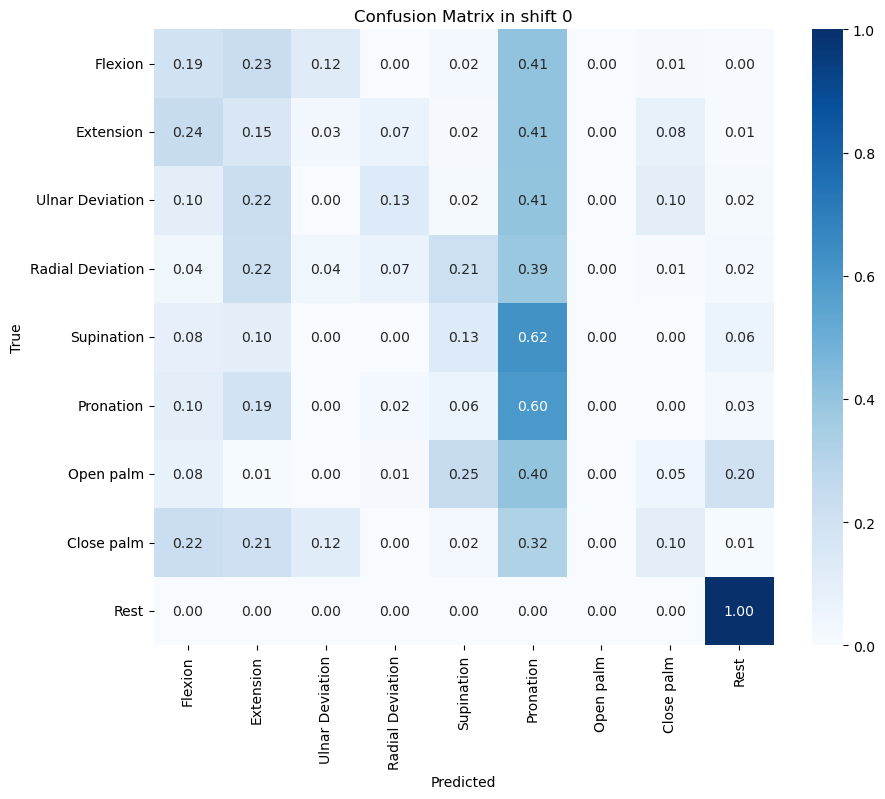

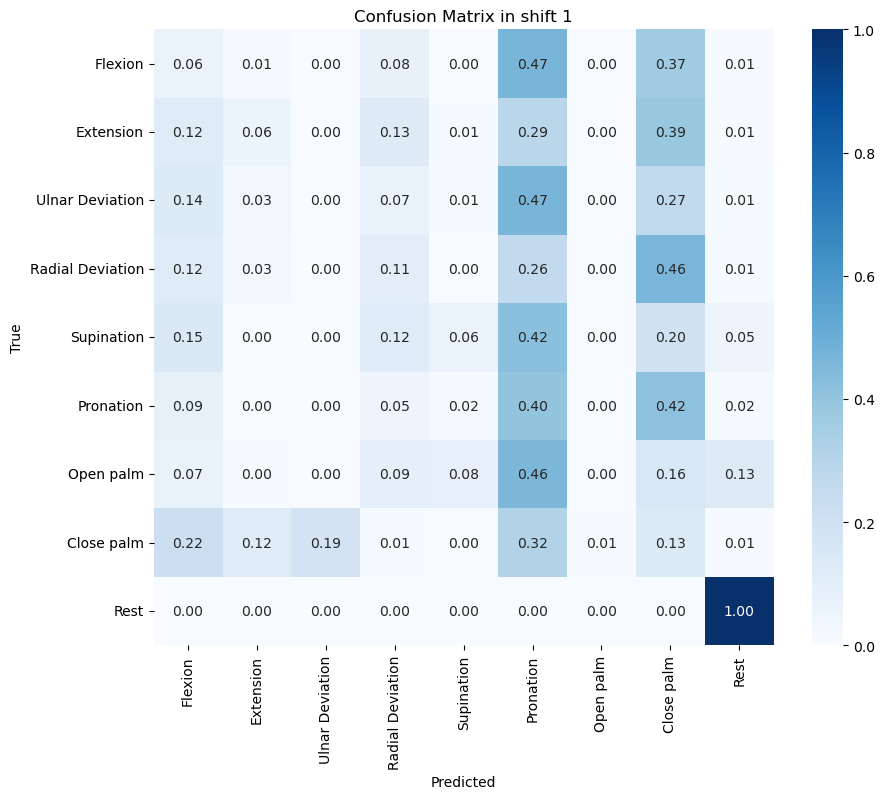

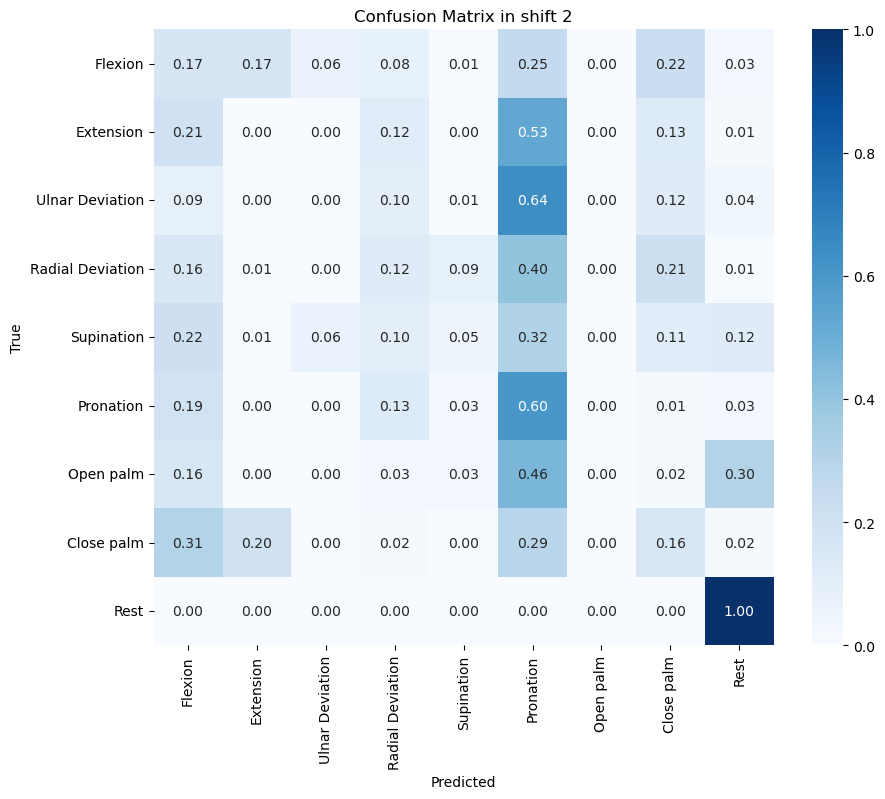

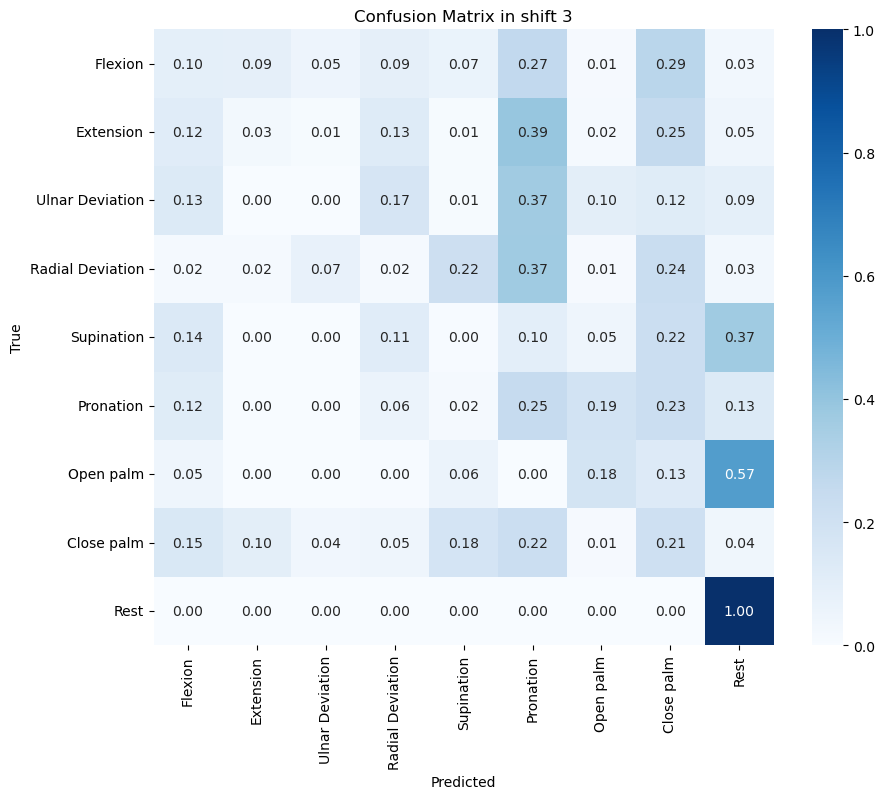

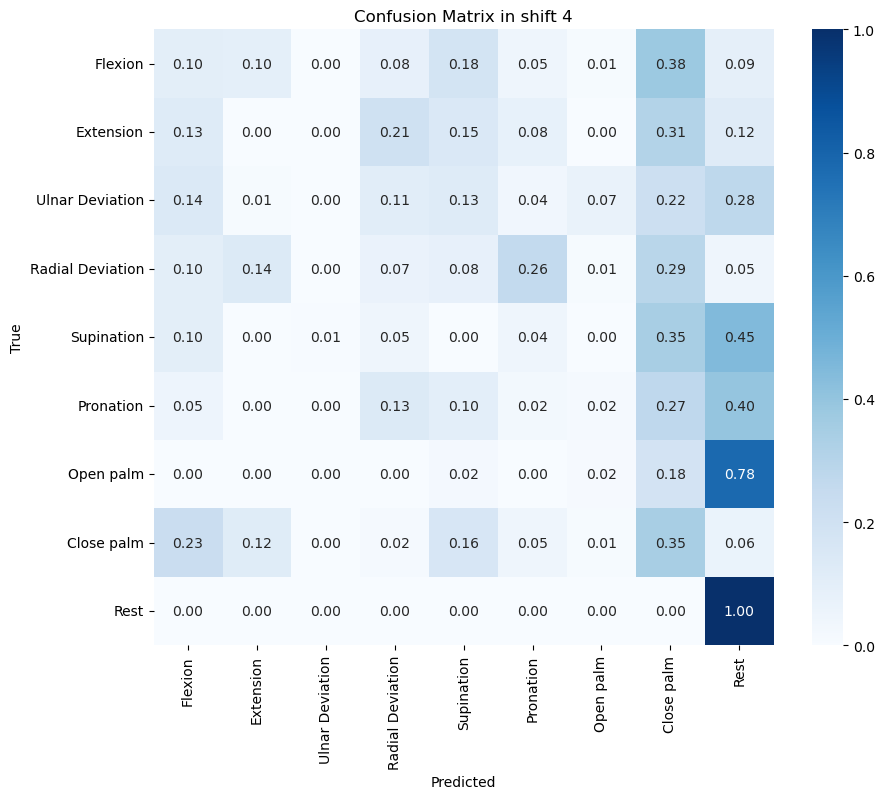

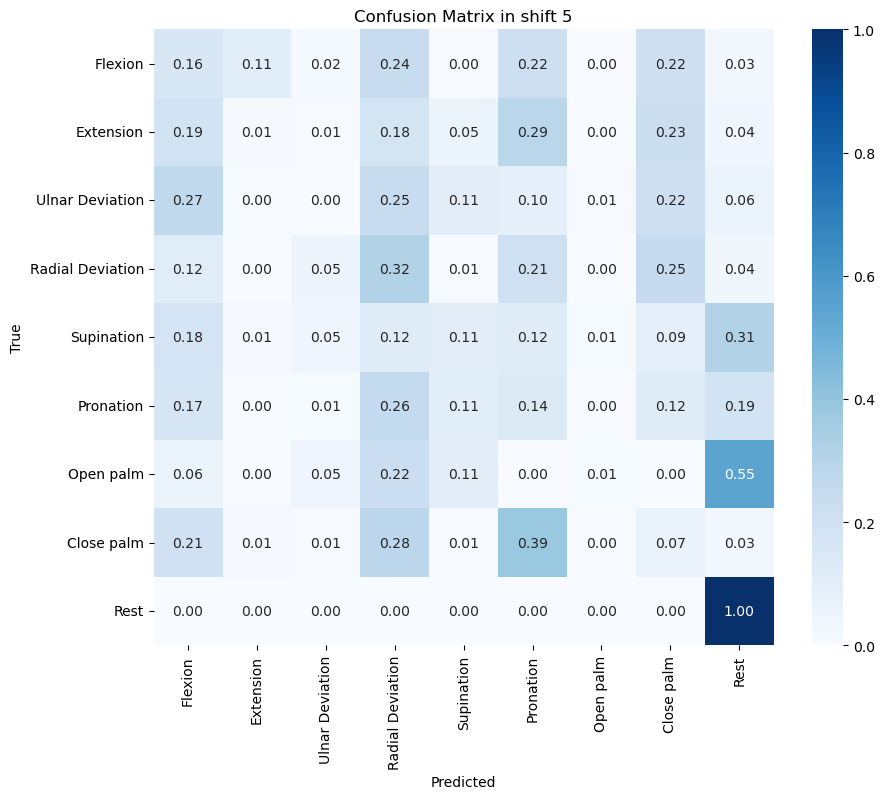

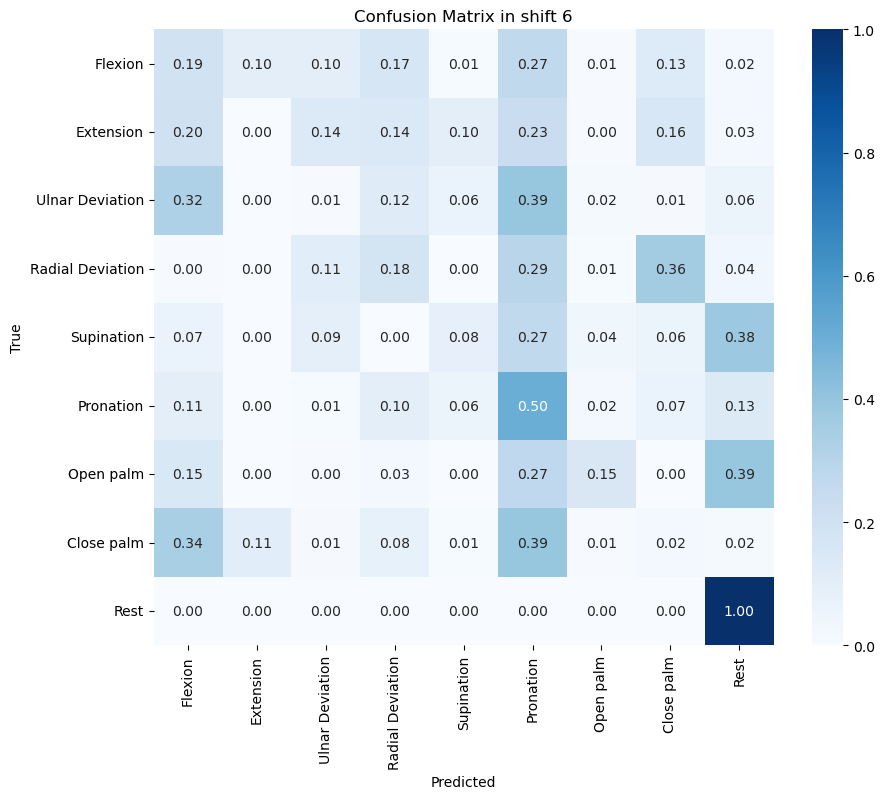

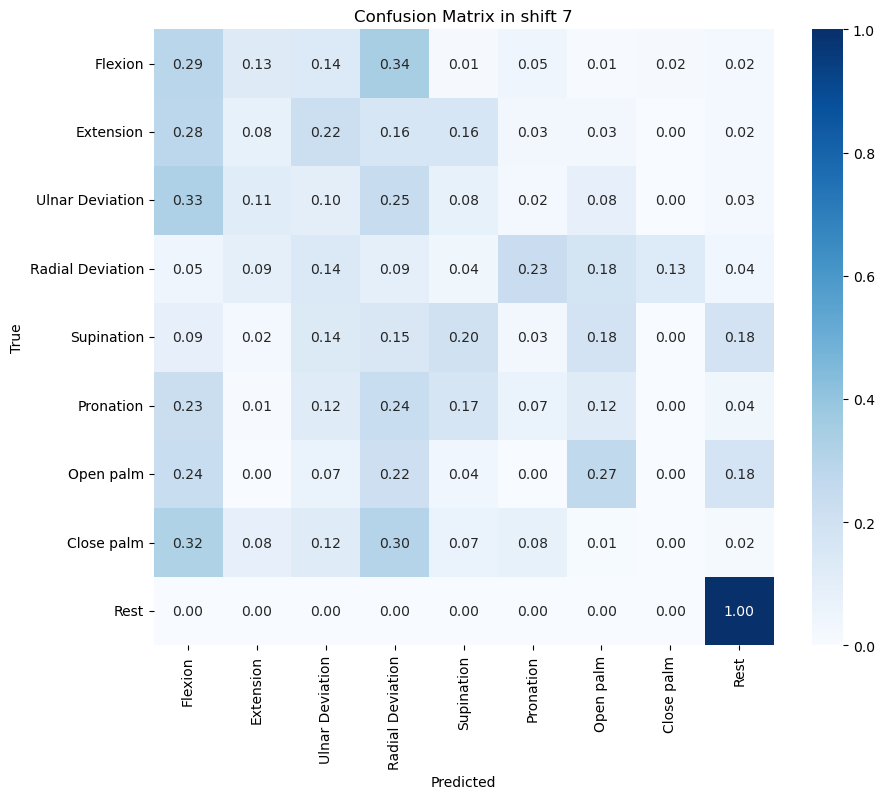

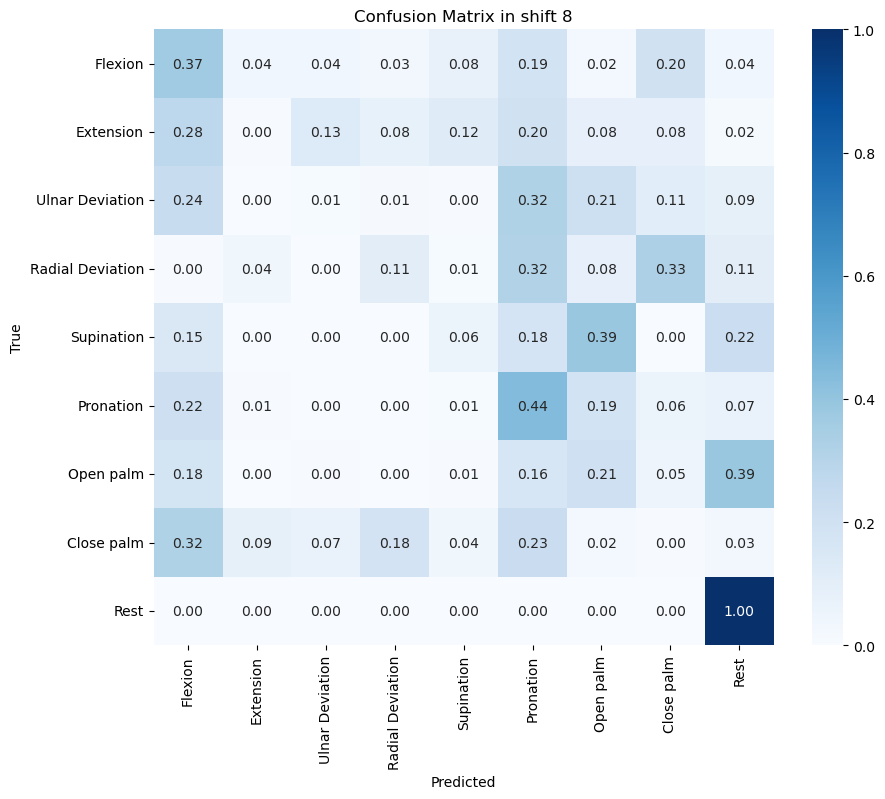

In [3]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize variables to accumulate predictions and true labels
# Define class names
class_names = ['Flexion', 'Extension', 'Ulnar Deviation', 'Radial Deviation',
               'Supination', 'Pronation', 'Open palm', 'Close palm', 'Rest']

conf_matrices_list_LogisReg = []

# Loop through shifts and folds
for shift in range(9):

    # Load the trained model
    reg = load(f'LogisticRegression_shift_{shift}_s2.joblib')

    # Make predictions on the test data
    predictions = reg.predict(X_test[shift])
        
    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_test[shift], predictions)
    conf_matrices_list_LogisReg.append(conf_matrix)

    total_samples_per_class = np.sum(conf_matrix, axis=1)
    conf_matrix_percent_LogReg = conf_matrix / total_samples_per_class[:, None]

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_percent_LogReg , annot=True, cmap='Blues', fmt='.2f', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix in shift {shift}')
    plt.show()


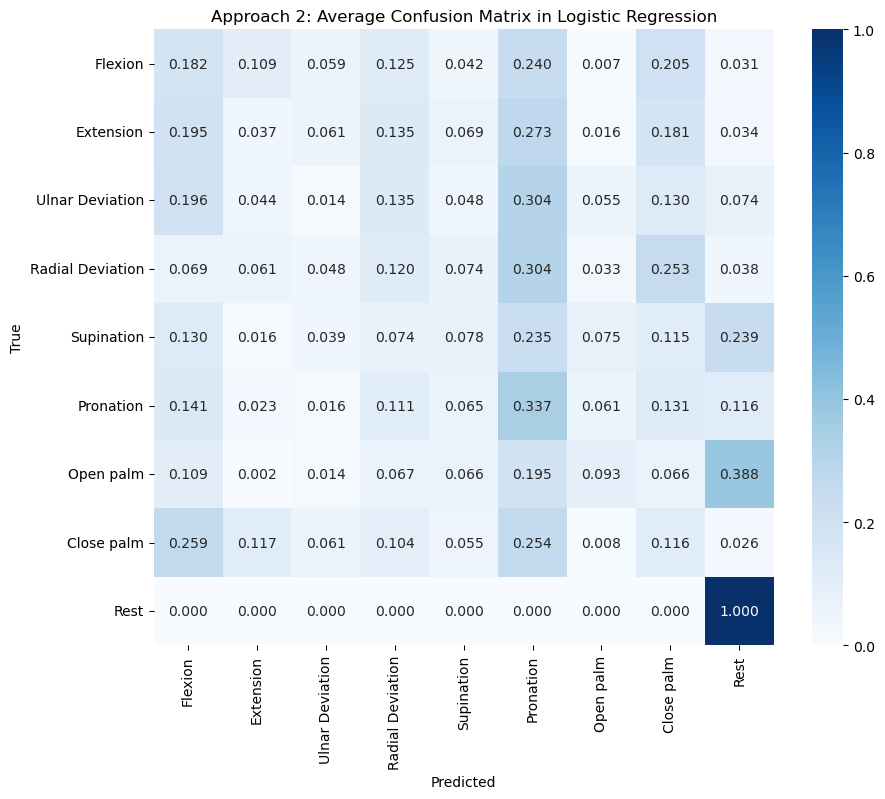

In [4]:
average_conf_matrix_LogReg = np.mean(conf_matrices_list_LogisReg, axis=0)
average_total_LogReg_samples_per_class = np.sum(average_conf_matrix_LogReg, axis=1)
average_conf_LogReg_matrix_percent = average_conf_matrix_LogReg / average_total_LogReg_samples_per_class[:, None]
# Plot the average confusion matrix
plt.figure(figsize=(10, 8))

sns.heatmap(average_conf_LogReg_matrix_percent, annot=True, cmap='Blues', fmt='.3f', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Approach 2: Average Confusion Matrix in Logistic Regression')
plt.show()

3.Feed Forward Neural Network

Testing

In [6]:
accuracies_FFNN_list_s2 = [0 for _ in range(9)]
for shift in range(9):
    modelWOoperator = FFNN(8,9)
    modelWOoperator.load_state_dict(torch.load(f"modelwoOperator_fshift_{shift}_s2.pt")) # loaded from the file: parameters learned during training.
    modelWOoperator.eval()

    test_shift_dataset = CustomSignalData(get_tensor(X_test[shift]), get_tensor(y_test[shift]))
    testshiftloader = torch.utils.data.DataLoader(test_shift_dataset, batch_size=24, shuffle=True)
    accuracies_FFNN_list_s2[shift] = clf_acc(modelWOoperator, testshiftloader, encoder = None)


print(accuracies_FFNN_list_s2)

RuntimeError: Error(s) in loading state_dict for FFNN:
	Missing key(s) in state_dict: "encoer.0.weight", "classidfer.0.weight". 
	Unexpected key(s) in state_dict: "encoder.0.weight", "classifer.0.weight". 

In [12]:
value_average_accuracies_FFNN_s2 = sum(accuracies_FFNN_list_s2) / 9 
print(value_average_accuracies_FFNN_s2)

0.4141277110562642


In [5]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

class_names = ['Flexion', 'Extension', 'Ulnar Deviation', 'Radial Deviation',
               'Supination', 'Pronation', 'Open palm', 'Close palm', 'Rest']
# Initialize variables to accumulate predictions and true labels
# Initialize variables to accumulate predictions and true labels
conf_matrices_FFNN_s2 = []

# Loop through shifts and folds
for shift in range(9):

    # Load the trained model
    modelWOoperator = FFNN(8, 9)
    modelWOoperator.load_state_dict(torch.load(f"modelwoOperator_fshift_{shift}_s2.pt"))
    modelWOoperator.eval()

    # Prepare the test dataset
    test_shift_dataset = CustomSignalData(get_tensor(X_test[shift]), get_tensor(y_test[shift]))
    test_shift_loader = torch.utils.data.DataLoader(test_shift_dataset, batch_size=24, shuffle=True)

    with torch.no_grad():
        for inputs, labels,_,_ in test_shift_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            pred = modelWOoperator(inputs)
            predicted = torch.argmax(pred,dim = 1)
            # all_predictions.extend(predicted.tolist())
            # all_true_labels.extend(labels.tolist())


        # # Evaluate the model and accumulate predictions and true labels
        # predictions, true_labels = clf_predictions(modelWOoperator, test_shift_loader, encoder=None)
        # all_predictions.extend(predictions)
        # all_true_labels.extend(true_labels)
        
    # Calculate the confusion matrix for the current shift
    conf_matrix = confusion_matrix(labels.tolist(), predicted.tolist())
    conf_matrices_FFNN_s2.append(conf_matrix)

    total_samples_per_class = np.sum(conf_matrix, axis=1)
    conf_matrix_percent = conf_matrix / total_samples_per_class[:, None]

    # Plot the average confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_percent, annot=True, cmap='Blues', fmt='.2f', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Approach 2: Average Confusion Matrix in Feed Forward Neural Network')
    plt.show()

RuntimeError: Error(s) in loading state_dict for FFNN:
	Missing key(s) in state_dict: "encoer.0.weight", "classidfer.0.weight". 
	Unexpected key(s) in state_dict: "encoder.0.weight", "classifer.0.weight". 

4. Self-supervised Learning

In [7]:
DEVICE = torch.device("cpu") # operations is in CPU or GPU.
M = torch.diag(torch.ones(8)).roll(-1,1) # Create a diagnoise matrix then shift it to the right
used_bases = [torch.linalg.matrix_power(M,i).to(DEVICE) for i in range (8)] #

N_points = 1000

accuracies_self_supervised_list_s2 = [0  for _ in range(9)]

for shift in range(9):
    classifier = FFNN(8,9) # This indicates that the neural network expects input data with 8 features and will produce output predictions across 9 classes.
    encoder = E(8,8)
    encoder.load_state_dict(torch.load(f"encoder_shift_{shift}_s2.pt")) # contains the learned parameters (weights and biases) of the encoder model
    recovered_points_= torch.load(f"reference_points_shift_{shift}_s2.pt") # These points represent reference points for inference or evaluation in the model
    classifier.load_state_dict(torch.load(f"classifier_shift_{shift}_s2.pt")) # contains the weights and biases learned during training.
    classifier.eval() # sets the model to evaluation mode.
    encoder.eval() # sets the model to evaluation mode.

    # Get the test data for the current shift and fold
    X_test_shift = X_test[shift]

    # Encode the test data using the encoder model
    y1 = encoder(get_tensor(X_test_shift))

    # Use the encoded data directly without rotation
    y_tr1 = classifier(y1).argmax(1)

    # Calculate accuracy and append to list
    accuracies_self_supervised_list_s2[shift] = (1 - torch.abs(torch.sign(y_tr1 - get_tensor(y_test[shift]).flatten()))).mean().item()
for accuracy in accuracies_self_supervised_list_s2:
    print(accuracy)

RuntimeError: Error(s) in loading state_dict for FFNN:
	Missing key(s) in state_dict: "encoer.0.weight", "classidfer.0.weight". 
	Unexpected key(s) in state_dict: "encoder.0.weight", "classifer.0.weight". 

In [20]:
print(accuracies_self_supervised_list_s2)

[0.21861015260219574, 0.19883345067501068, 0.20378808677196503, 0.21621572971343994, 0.19385793805122375, 0.2079939991235733, 0.24355219304561615, 0.17547810077667236, 0.22497816383838654]


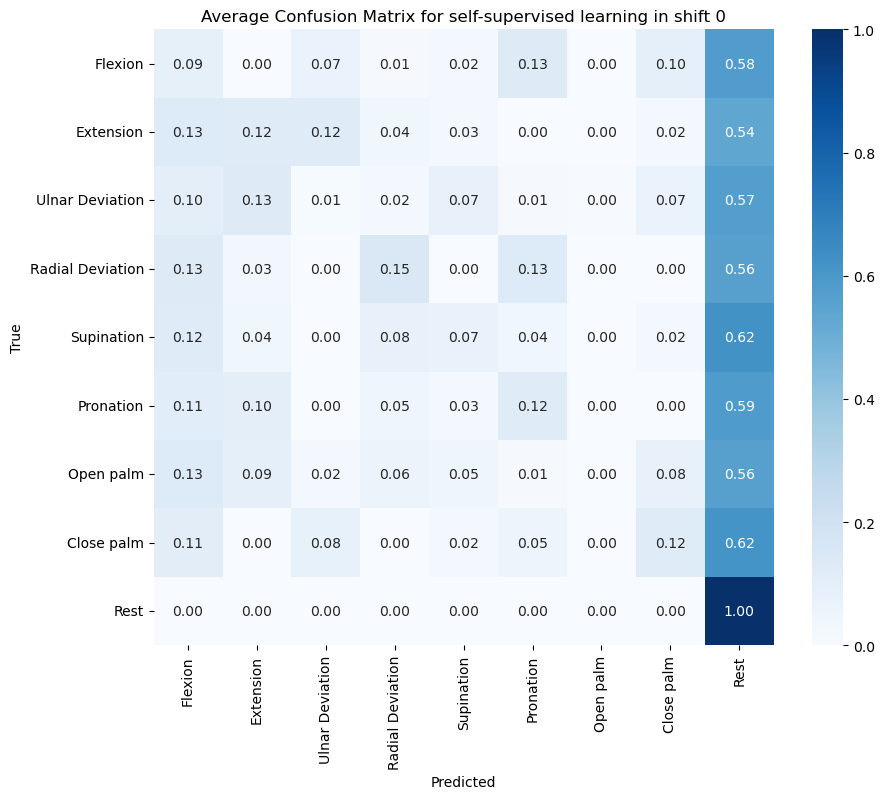

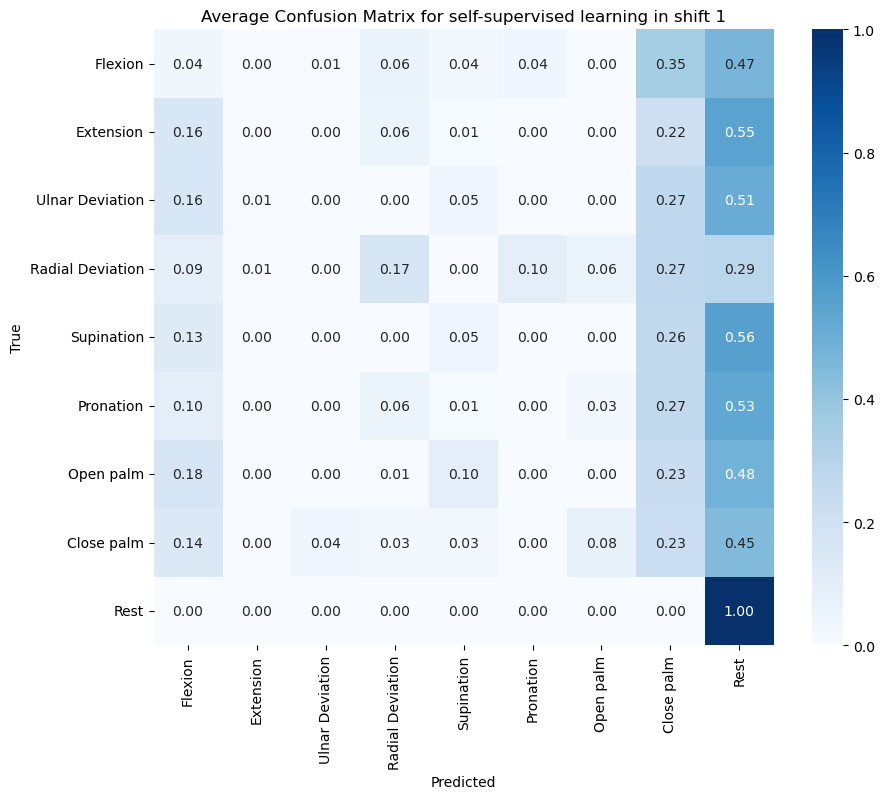

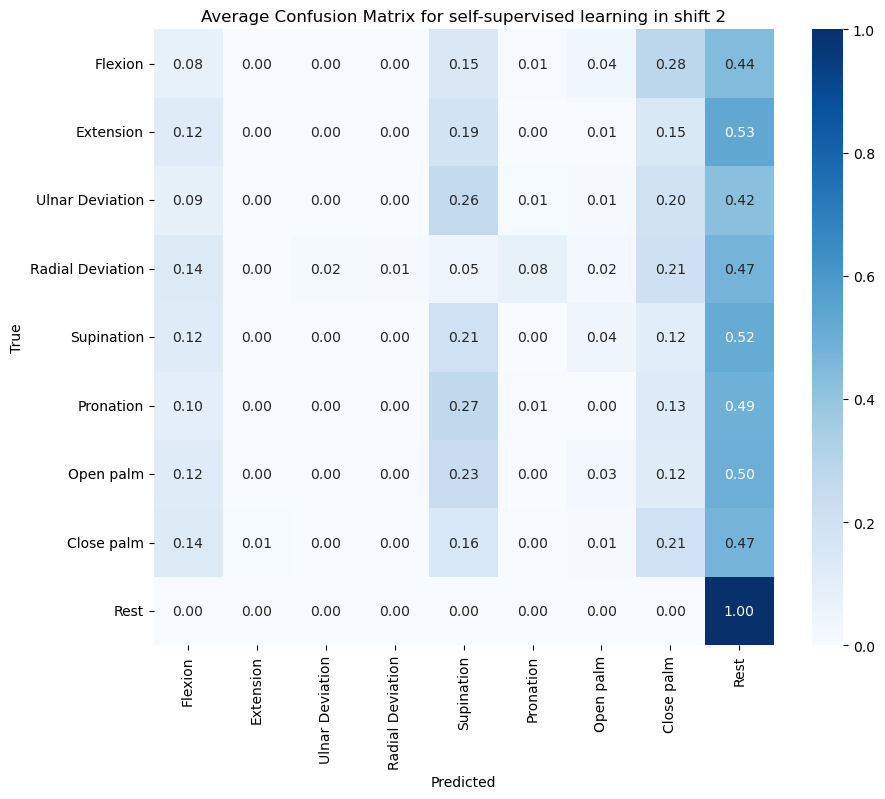

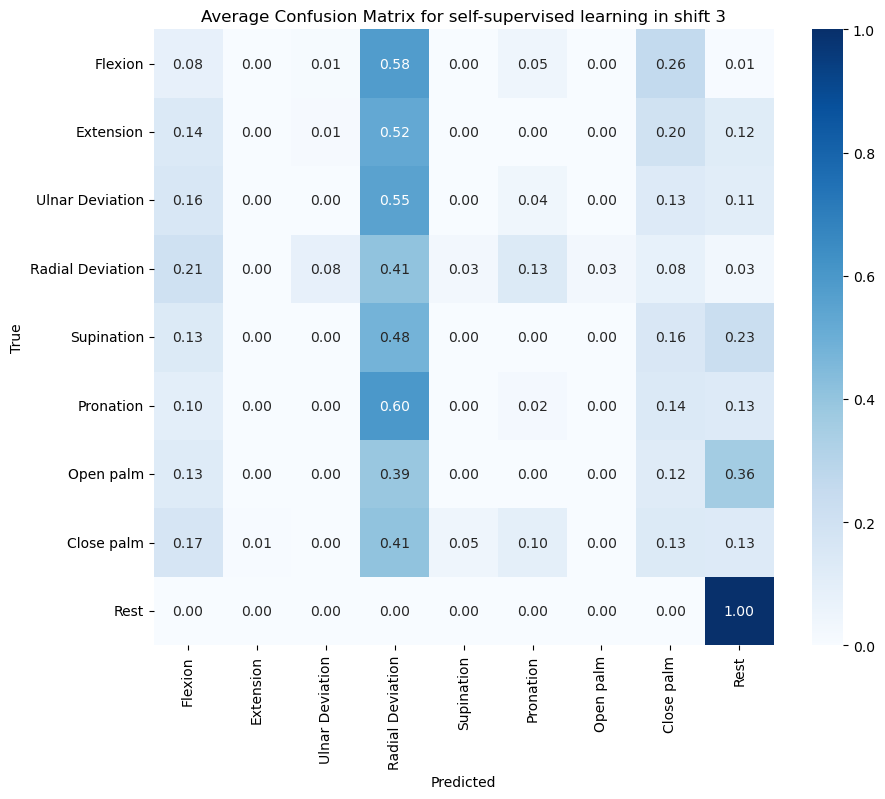

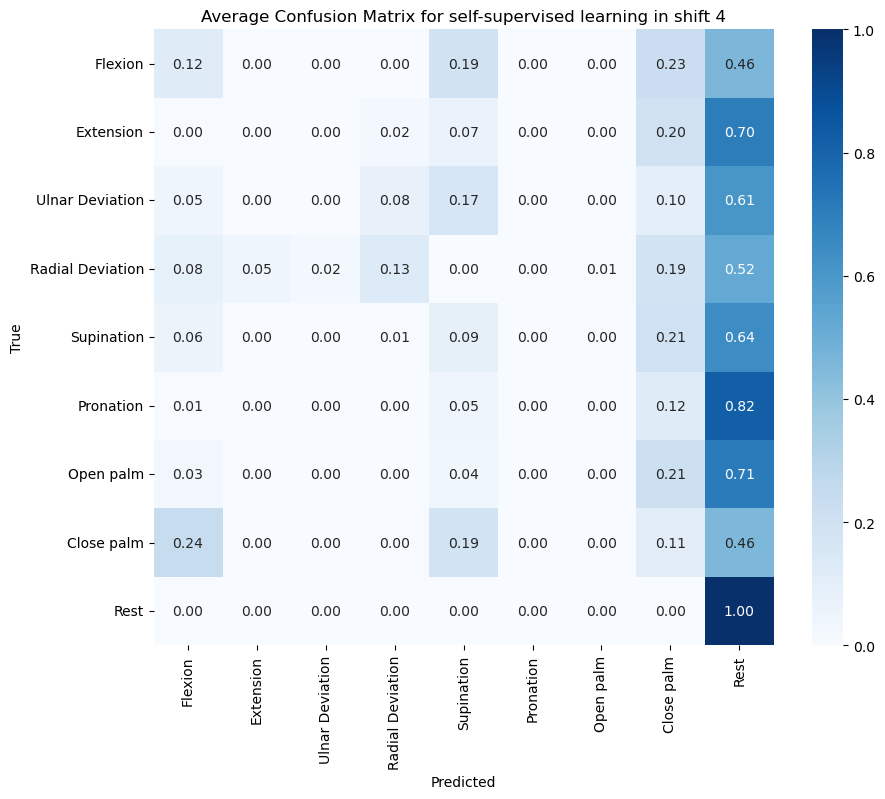

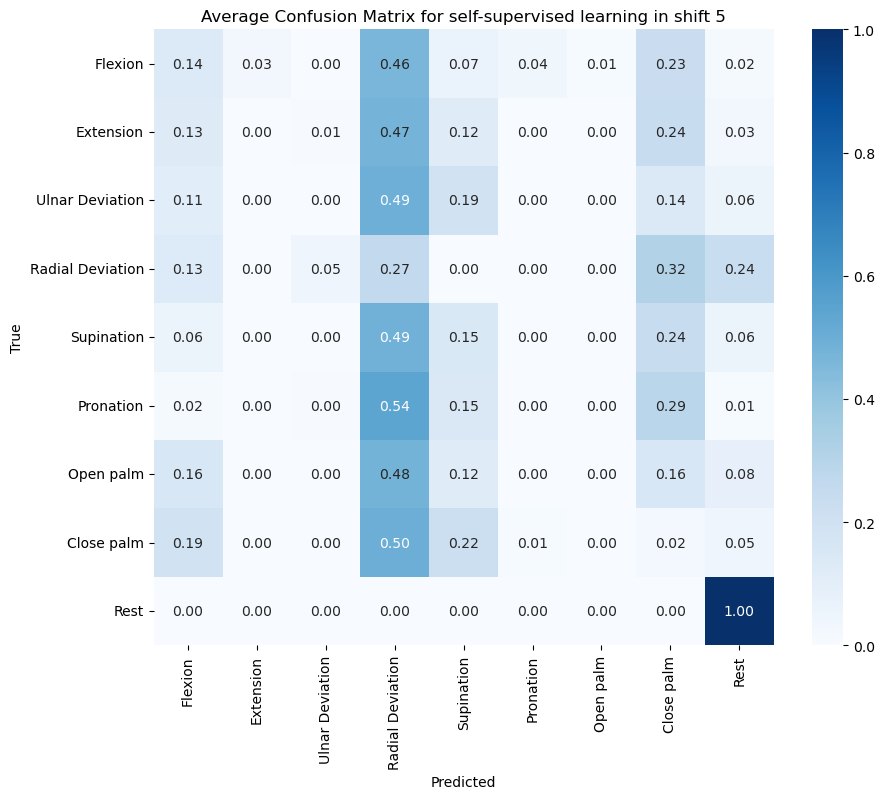

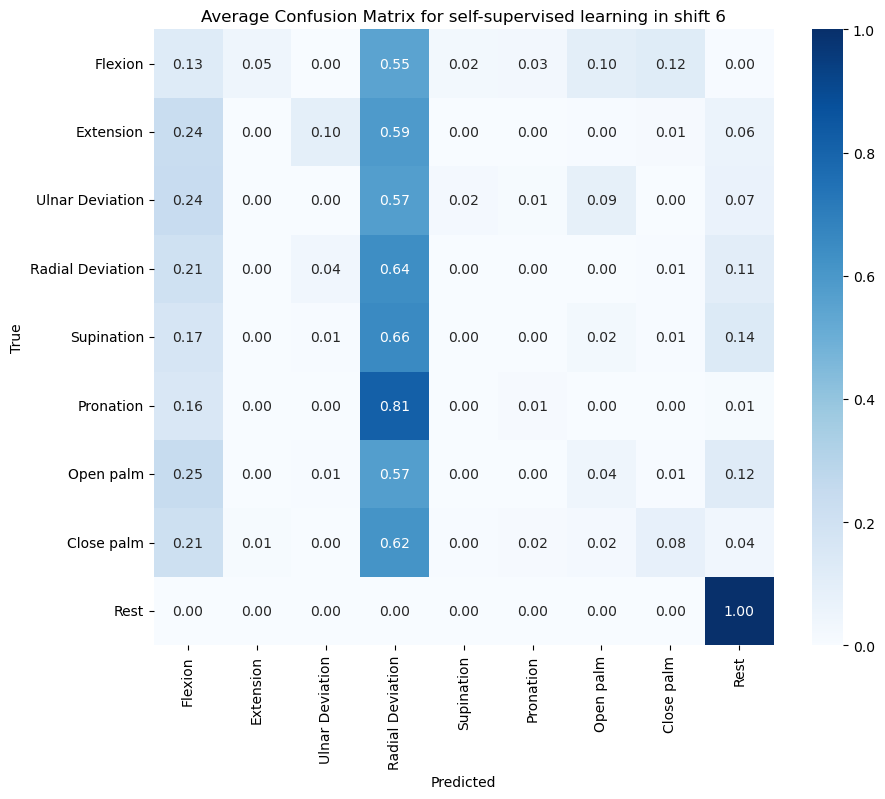

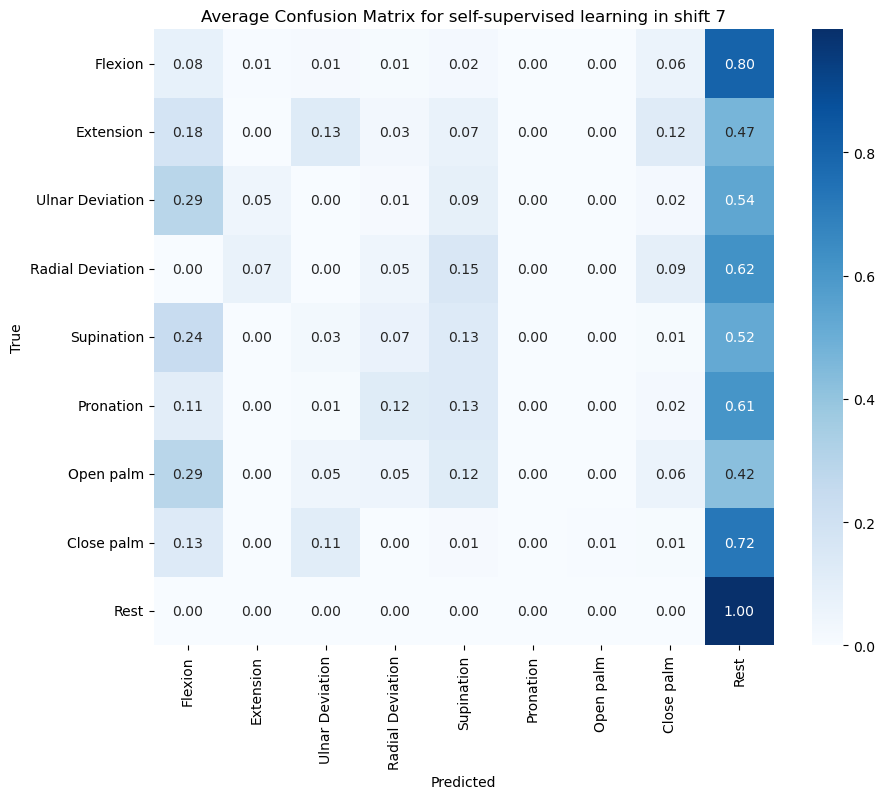

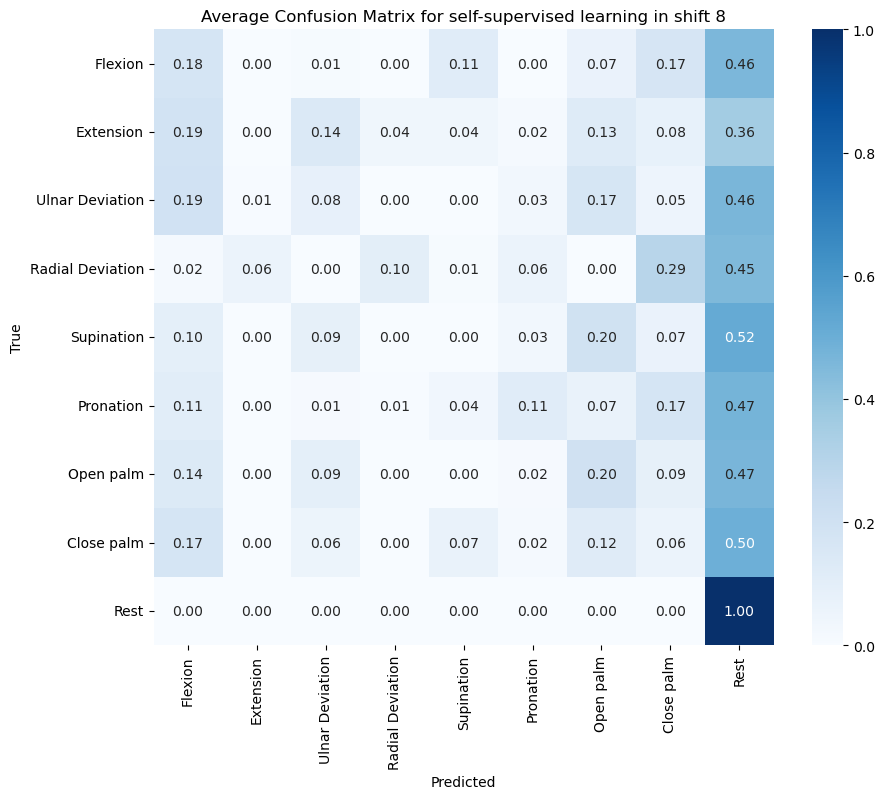

In [7]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Initialize variables to accumulate predictions and true labels
conf_matrices_self_supervised_s2 = []
class_names = ['Flexion', 'Extension', 'Ulnar Deviation', 'Radial Deviation',
               'Supination', 'Pronation', 'Open palm', 'Close palm', 'Rest']
# Loop through shifts and folds
for shift in range(9):

    #classifier = FFNN(8,9) # This indicates that the neural network expects input data with 8 features and will produce output predictions across 9 classes.
    encoder = E(8,8)
    encoder.load_state_dict(torch.load(f"encoder_shift_{shift}_s2.pt")) # contains the learned parameters (weights and biases) of the encoder model
    recovered_points_= torch.load(f"reference_points_shift_{shift}_s2.pt") # These points represent reference points for inference or evaluation in the model
    classifier.load_state_dict(torch.load(f"classifier_shift_{shift}_s2.pt")) # contains the weights and biases learned during training.
    classifier.eval() # sets the model to evaluation mode.
    encoder.eval() # sets the model to evaluation mode.

    # Get the test data for the current shift and fold
    X_test_shift = X_test[shift]
    # Encode the test data using the encoder model
    y1 = encoder(get_tensor(X_test_shift))
    # Use the encoded data directly without rotation
    y_tr1 = classifier(y1).argmax(1)

    # all_predictions.extend(y_tr1.cpu().numpy())
    # all_true_labels.extend(get_tensor(y_test[shift][k_fold]).flatten())

        
    # Calculate the confusion matrix for the current shift
    conf_matrix = confusion_matrix(get_tensor(y_test[shift]).flatten(), y_tr1.cpu().numpy())
    conf_matrices_self_supervised_s2.append(conf_matrix)

    total_samples_per_class = np.sum(conf_matrix, axis=1)
    conf_matrix_percent = conf_matrix / total_samples_per_class[:, None]

    # Plot the average confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_percent, annot=True, cmap='Blues', fmt='.2f', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Average Confusion Matrix for self-supervised learning in shift {shift}')
    plt.show()


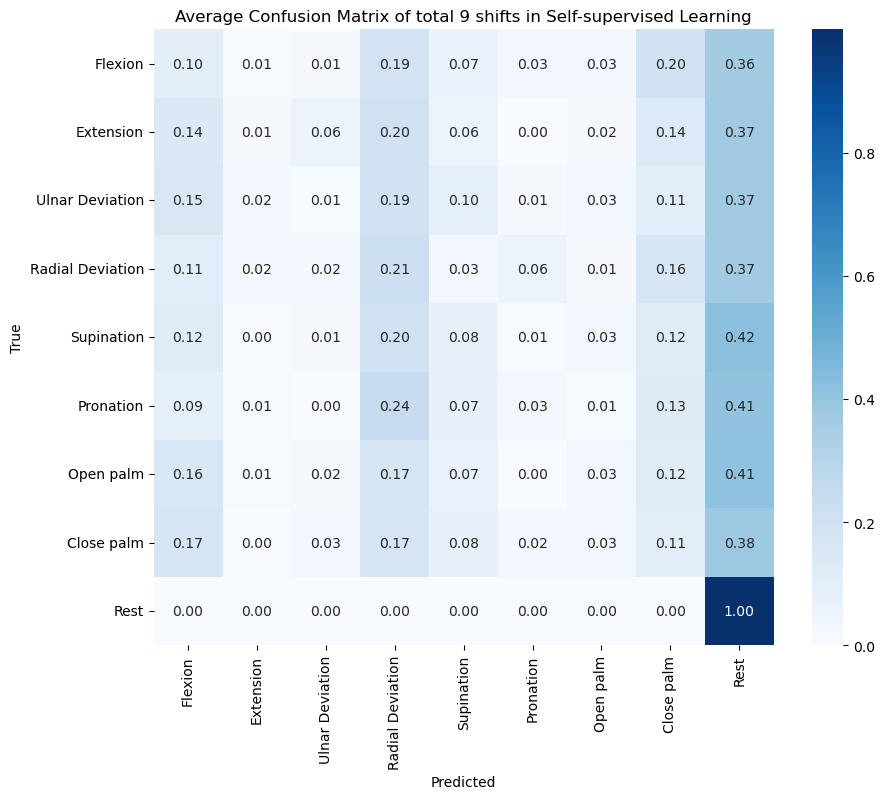

In [8]:
conf_matrices_self_supervised_s2 

average_conf_matrix__self_supervised = np.mean(conf_matrices_self_supervised_s2 , axis=0)
average_total__self_supervised_samples_per_class = np.sum(average_conf_matrix__self_supervised, axis=1)
average_conf__self_supervised_matrix_percent = average_conf_matrix__self_supervised / average_total__self_supervised_samples_per_class[:, None]
# Plot the average confusion matrix
plt.figure(figsize=(10, 8))

sns.heatmap(average_conf__self_supervised_matrix_percent, annot=True, cmap='Blues', fmt='.2f', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Average Confusion Matrix of total 9 shifts in Self-supervised Learning')
plt.show()

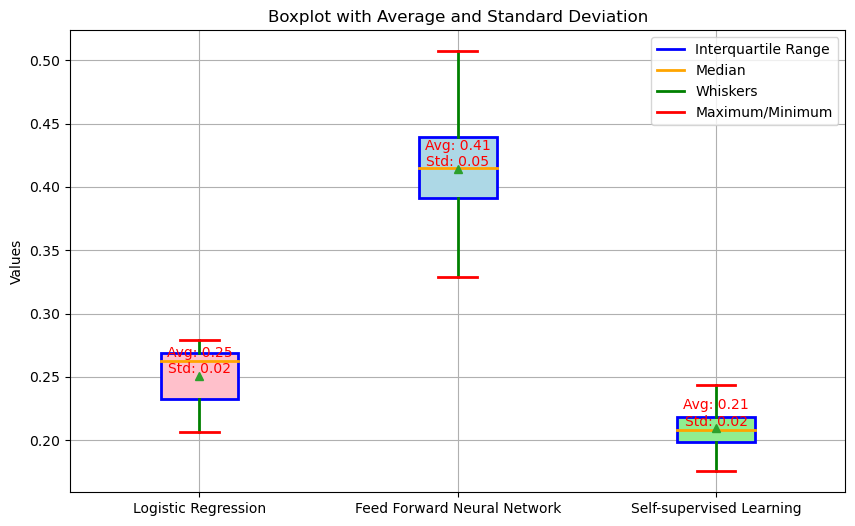

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Data
data = [
    [0.27951022161755756, 0.23442211055276382, 0.26487983561154294, 0.23040405482581383, 0.20656934306569344, 0.23281897413916275, 0.2685932699864257, 0.2626809651474531, 0.2758688325814447],
    [0.43924633969466403, 0.32880239682488666, 0.3914252027236628, 0.5071109937970593, 0.46367293333380916, 0.4038969860969058, 0.4165380776768404, 0.36183176126720873, 0.4146247080913404],
    [0.21861015260219574, 0.19883345067501068, 0.20378808677196503, 0.21621572971343994, 0.19385793805122375, 0.2079939991235733, 0.24355219304561615, 0.17547810077667236, 0.22497816383838654]
]

# Calculate average and standard deviation
averages = [np.mean(lst) for lst in data]
std_devs = [np.std(lst) for lst in data]

# Plot boxplot with customized colors and statistics
plt.figure(figsize=(10, 6))
colors = ['pink', 'lightblue', 'lightgreen']
boxprops = dict(color="blue", linewidth=2)
medianprops = dict(color="orange", linewidth=2)
whiskerprops = dict(color="green", linewidth=2)
capprops = dict(color="red", linewidth=2)
box = plt.boxplot(data, showmeans=True, patch_artist=True, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)


plt.xticks([1, 2, 3], ['Logistic Regression', 'Feed Forward Neural Network', 'Self-supervised Learning'])
plt.ylabel('Values')
plt.title('Boxplot with Average and Standard Deviation')
plt.grid(True)

# Add average and standard deviation text
for i in range(len(data)):
    plt.text(i + 1, averages[i], f'Avg: {averages[i]:.2f}\nStd: {std_devs[i]:.2f}', horizontalalignment='center', verticalalignment='bottom', fontsize=10, color='red')

# Add legend explaining box components
legend_elements = [
    plt.Line2D([0], [0], color='blue', lw=2, label='Interquartile Range'),
    plt.Line2D([0], [0], color='orange', lw=2, label='Median'),
    plt.Line2D([0], [0], color='green', lw=2, label='Whiskers'),
    plt.Line2D([0], [0], color='red', lw=2, label='Maximum/Minimum')
]
plt.legend(handles=legend_elements)

plt.show()


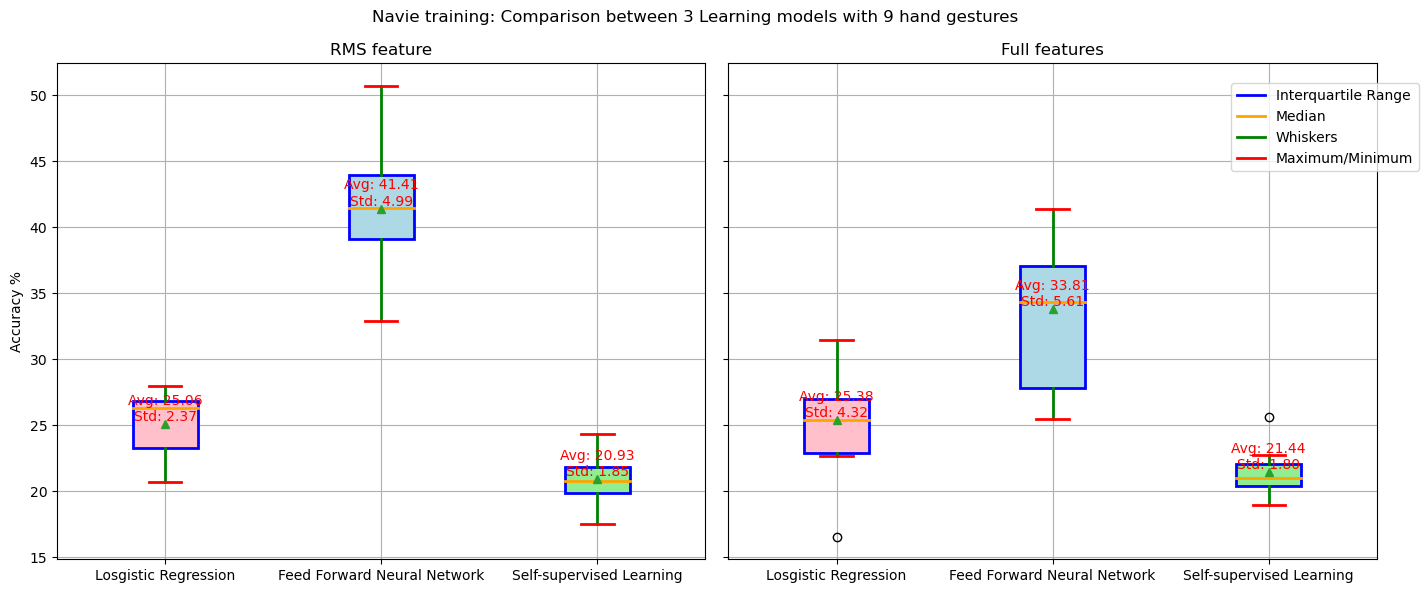

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# First dataset
data_2 = [
    [0.31428461700942834, 0.2700929891576957, 0.26771144373228856, 0.22672762849448824, 0.16547138079681428, 0.24464458648072826, 0.22919722115013508, 0.2536699374179093, 0.3127895496316549],
    [0.34319727857884724, 0.3708140436111501, 0.4138491202140714, 0.41232532157503354, 0.34133777448454794, 0.2684324651534174, 0.25439814738066935, 0.27824760535671494, 0.36025056971198877],
    [0.2209036648273468, 0.18979820609092712, 0.21084463596343994, 0.20373132824897766, 0.20349499583244324, 0.2065465748310089, 0.21016982197761536, 0.2272270768880844, 0.2565314769744873]
]


# Second dataset
data_1 = [
    [0.27951022161755756, 0.23442211055276382, 0.26487983561154294, 0.23040405482581383, 0.20656934306569344, 0.23281897413916275, 0.2685932699864257, 0.2626809651474531, 0.2758688325814447],
    [0.43924633969466403, 0.32880239682488666, 0.3914252027236628, 0.5071109937970593, 0.46367293333380916, 0.4038969860969058, 0.4165380776768404, 0.36183176126720873, 0.4146247080913404],
    [0.21861015260219574, 0.19883345067501068, 0.20378808677196503, 0.21621572971343994, 0.19385793805122375, 0.2079939991235733, 0.24355219304561615, 0.17547810077667236, 0.22497816383838654]
]

# Multiply all values by 100
data_1 = [[value * 100 for value in lst] for lst in data_1]
data_2 = [[value * 100 for value in lst] for lst in data_2]

# Calculate average and standard deviation for each dataset
averages_1 = [np.mean(lst) for lst in data_1]
std_devs_1 = [np.std(lst) for lst in data_1]

averages_2 = [np.mean(lst) for lst in data_2]
std_devs_2 = [np.std(lst) for lst in data_2]

# Plotting subplots with shared y-axis
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True)

colors = ['pink', 'lightblue', 'lightgreen']
boxprops = dict(color="blue", linewidth=2)
medianprops = dict(color="orange", linewidth=2)
whiskerprops = dict(color="green", linewidth=2)
capprops = dict(color="red", linewidth=2)

# Plot for first dataset
box_1 = ax1.boxplot(data_1, showmeans=True, patch_artist=True, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)
for patch, color in zip(box_1['boxes'], colors):
    patch.set_facecolor(color)
ax1.set_xticks([1, 2, 3])
ax1.set_xticklabels(['Losgistic Regression', 'Feed Forward Neural Network', 'Self-supervised Learning'])
ax1.set_ylabel('Accuracy %')
ax1.set_title('RMS feature')
ax1.grid(True)

# Add average and standard deviation text for first dataset
for i in range(len(data_1)):
    ax1.text(i + 1, averages_1[i], f'Avg: {averages_1[i]:.2f}\nStd: {std_devs_1[i]:.2f}', horizontalalignment='center', verticalalignment='bottom', fontsize=10, color='red')

# Plot for second dataset
box_2 = ax2.boxplot(data_2, showmeans=True, patch_artist=True, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)
for patch, color in zip(box_2['boxes'], colors):
    patch.set_facecolor(color)
ax2.set_xticks([1, 2, 3])
ax2.set_xticklabels(['Losgistic Regression', 'Feed Forward Neural Network', 'Self-supervised Learning'])
ax2.set_title('Full features')
ax2.grid(True)

# Add average and standard deviation text for second dataset
for i in range(len(data_2)):
    ax2.text(i + 1, averages_2[i], f'Avg: {averages_2[i]:.2f}\nStd: {std_devs_2[i]:.2f}', horizontalalignment='center', verticalalignment='bottom', fontsize=10, color='red')

# Add legend explaining box components
legend_elements = [
    plt.Line2D([0], [0], color='blue', lw=2, label='Interquartile Range'),
    plt.Line2D([0], [0], color='orange', lw=2, label='Median'),
    plt.Line2D([0], [0], color='green', lw=2, label='Whiskers'),
    plt.Line2D([0], [0], color='red', lw=2, label='Maximum/Minimum')
]
fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.95, 0.7))


# Common title
fig.suptitle('Navie training: Comparison between 3 Learning models with 9 hand gestures')

plt.tight_layout()
plt.show()
